In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import sep
import math
import keras
import numpy as np
from astropy.io import fits
from astropy.visualization import ZScaleInterval
from astropy import wcs
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

import random 
import aplpy
from astroquery.sdss import SDSS

np.random.seed(123)  # for reproducibility

Using TensorFlow backend.


In [2]:
def gauss(shape, th=0.0, sigma=(1.0, 1.0)):
    """Create a numpy array of given shape, 
    with a centered 2D un-normalized Gaussian
    with (sigma_x, sigma_y) covariance matrix,
    rotated th radians counter-clockwise."""
    sx, sy = sigma
    h, w = shape
    cov = np.array([[sy, 0.], [0., sx]])
    rotm = np.array([[np.cos(th), np.sin(th)], [-np.sin(th), np.cos(th)]])
    cov_rot = rotm.T.dot(cov).dot(rotm)
    covinv = np.linalg.inv(cov_rot)
    xv = x, y = np.mgrid[:h,:w]
    x0 = np.array([h / 2, w / 2])
    chisq = np.zeros(shape)
    # Double loop because I can't make it work with np.tensordot
    for i in range(h):
        for j in range(w):
            chisq[i, j] = ((xv[:,i,j] - x0).dot(covinv)).dot((xv[:,i,j] - x0))
    g = np.exp(-0.5 * chisq)
    # g = g / np.sum(g)
    return g

In [15]:
def make_samples(n_samples):
    """Create n_samples of pairs of (new, reference) images
    in which `new` may or may not contain a transient with equal probability.
    The sources, when present, have random parameters of `gauss`."""
    thumb_size = (21, 21)
    noise_sigma = 2.0
    sky_mean = 10.0
    smp_x_list = []
    smp_y_list = []    
    for i in range(n_samples):
        bkg = np.random.normal(sky_mean, noise_sigma, size=thumb_size)
        th = np.random.rand() * 2.0 * np.pi
        amp = 5.0 + np.random.rand() * 15.0
        sx = 0.5 + np.random.rand() * 1.5
        sy = 0.5 + np.random.rand() * 1.5
        src = (sky_mean + amp * noise_sigma) * gauss(thumb_size, th=th, sigma=(sx, sy))
        img1 = src + bkg

        bkg = np.random.normal(sky_mean, noise_sigma, size=thumb_size)
        has_transient = np.random.rand() > 0.5
        if has_transient:
            src = np.zeros(thumb_size)
        else:
            th = np.random.rand() * 2.0 * np.pi
            amp = 5.0 + np.random.rand() * 15.0
            sx = 0.5 + np.random.rand() * 1.5
            sy = 0.5 + np.random.rand() * 1.5
            src = (sky_mean + amp * noise_sigma) * gauss(thumb_size, th=th, sigma=(sx, sy))
        img2 = src + bkg
        
        smp_x_list.append([img1, img2])
        smp_y_list.append(1 if has_transient else 0)
    return np.array(smp_x_list), np.array(smp_y_list)

Creating simulation data

In [16]:
dataset, labels = make_samples(10000) 

In [17]:
dataset.shape

(10000, 2, 21, 21)

In [22]:
dataset2 = np.zeros((10000,21,21,2))

In [23]:
dataset2.shape

(10000, 21, 21, 2)

In [24]:
dataset2[:,:,:,0] = dataset[:,0,:,:]
dataset2[:,:,:,1] = dataset[:,1,:,:]

In [25]:
dataset2.shape

(10000, 21, 21, 2)

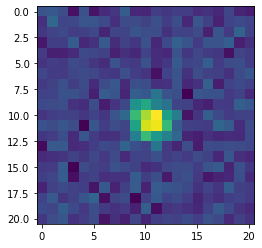

In [34]:
plt.imshow(dataset2[0,:,:,1])

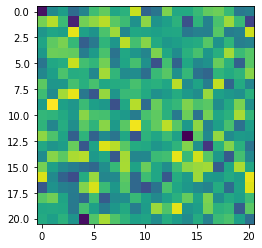

In [36]:
plt.imshow(dataset2[1,:,:,1])
plt.imsave('simulated_background_1.png', dataset2[1,:,:,1])

In [14]:
labels[5]

1

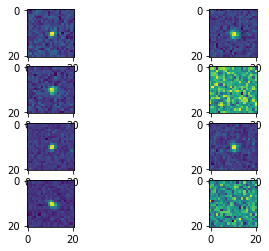

In [32]:
f, axarr = plt.subplots(4,2)
axarr[0,0].imshow(dataset[0,0,:,:])
axarr[0,1].imshow(dataset[0,1,:,:])
axarr[1,0].imshow(dataset[1,0,:,:])
axarr[1,1].imshow(dataset[1,1,:,:])
axarr[2,0].imshow(dataset[2,0,:,:])
axarr[2,1].imshow(dataset[2,1,:,:])
axarr[3,0].imshow(dataset[5,0,:,:])
axarr[3,1].imshow(dataset[5,1,:,:])

/home/kasiawardega/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


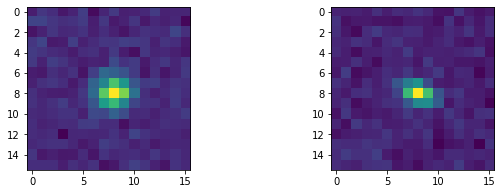

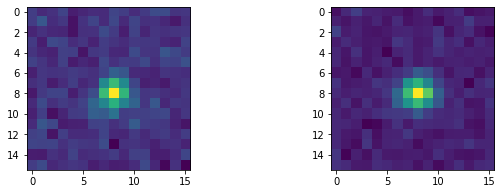

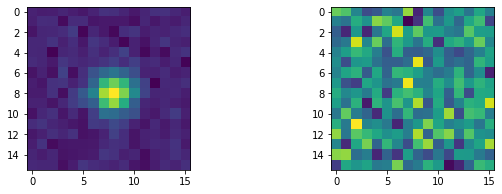

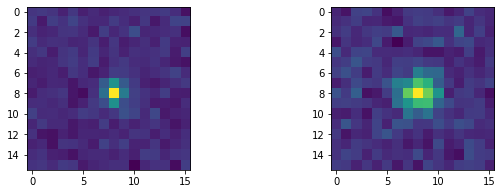

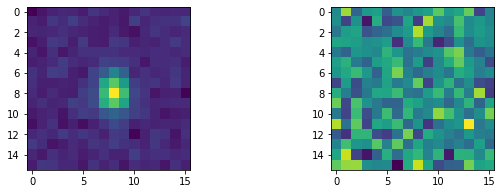

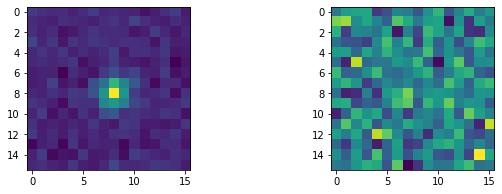

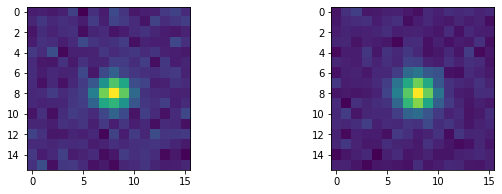

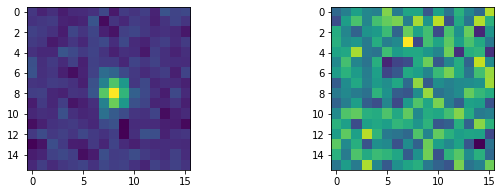

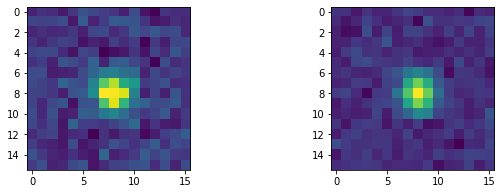

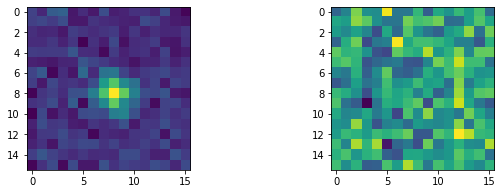

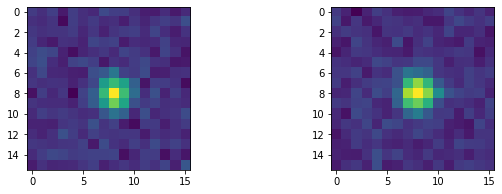

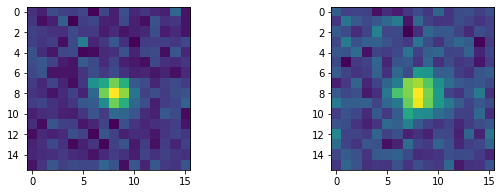

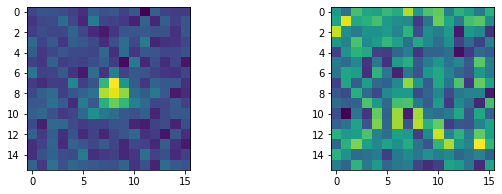

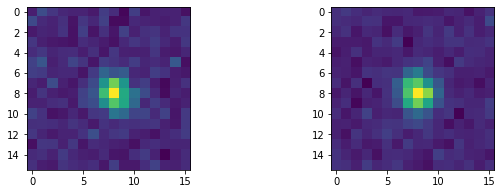

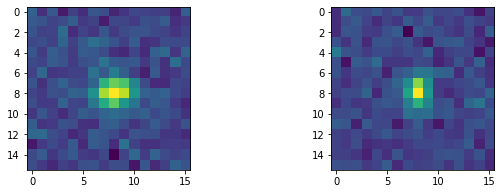

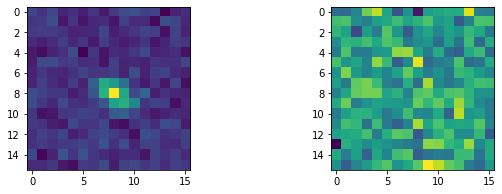

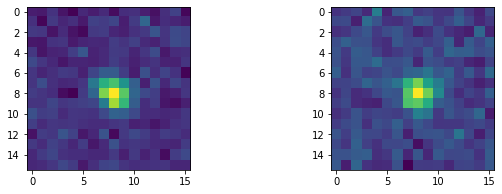

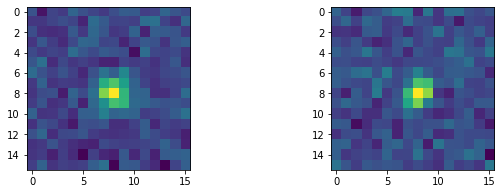

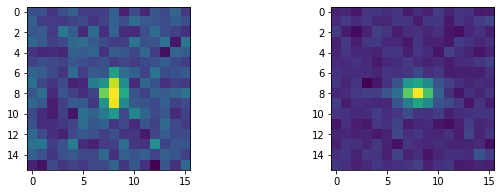

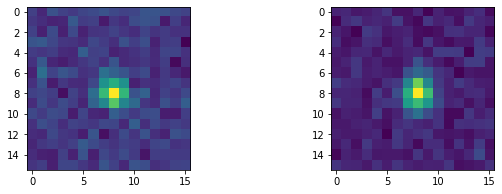

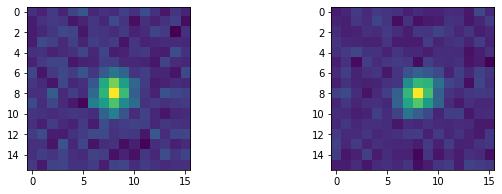

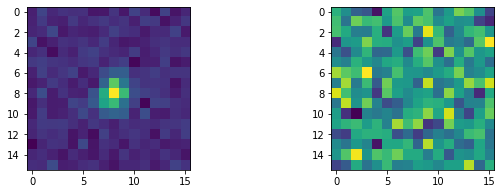

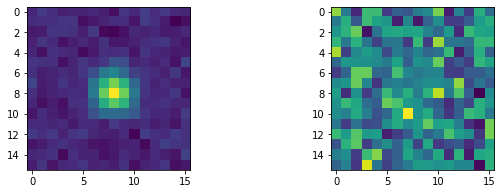

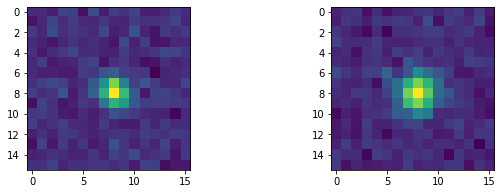

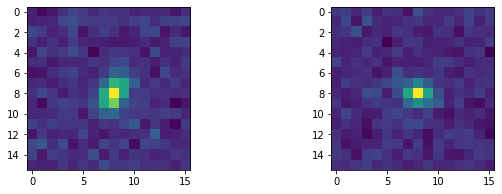

In [16]:
for i in range(25):
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.imshow(dataset[i,0,:,:])
    ax2.imshow(dataset[i,1,:,:])

In [37]:
labels.shape


(10000,)

In [38]:
dataset_train = dataset2[0:8000, :,:,:]
dataset_test = dataset2[8000:10000,:,:,:]
labels_train = labels[0:8000]
labels_test = labels[8000:10000]

In [39]:
labels_train.shape

(8000,)

In [40]:
labels_test.shape

(2000,)

In [41]:
#we need to transform labels to format (N,2) - now is only (N,1)

In [42]:
from keras.utils import np_utils

In [43]:
labels_train_2 = np_utils.to_categorical(labels_train)

In [46]:
labels_test_2 = np_utils.to_categorical(labels_test)

CNN - one input

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Conv3D, MaxPooling2D, Dropout

In [22]:
#create model
model = Sequential()
#add model layers
model.add(Conv2D(10, kernel_size=3, activation='relu', input_shape=(16,16,2)))
model.add(Conv2D(5, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))
model.add(Conv2D(3, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 10)        190       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 5)         455       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 5)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 5)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 3)           138       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 3)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3)                

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
model.fit(dataset_train, labels_train_2, validation_data=(dataset_test, labels_test_2), epochs=10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 2s 267us/step - loss: 0.4214 - accuracy: 0.8192 - val_loss: 0.0997 - val_accuracy: 1.0000
Epoch 2/10
8000/8000 [==============================] - 1s 111us/step - loss: 0.0805 - accuracy: 0.9868 - val_loss: 0.0222 - val_accuracy: 1.0000
Epoch 3/10
8000/8000 [==============================] - 1s 112us/step - loss: 0.0529 - accuracy: 0.9894 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 4/10
8000/8000 [==============================] - 1s 112us/step - loss: 0.0419 - accuracy: 0.9921 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 5/10
8000/8000 [==============================] - 1s 111us/step - loss: 0.0404 - accuracy: 0.9930 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 6/10
8000/8000 [==============================] - 1s 111us/step - loss: 0.0542 - accuracy: 0.9887 - val_loss: 0.0077 - va

In [58]:
labels_predict = model.predict(dataset_train)

In [60]:
labels_predict = np.round(labels_predict)

In [61]:
labels_predict = labels_predict.astype(int)

In [62]:
labels_predict[0:200]

array([[0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0,

In [57]:
labels_train_2[0:200]

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.

CNN - double input

In [67]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras import backend as K


In [89]:
inputA = keras.layers.Input(shape=(16,16))
inputB = keras.layers.Input(shape=(16,16))

# the first branch operates on the first input
x = Dense(64, activation="relu")(inputA)
x = Dense(32, activation="relu")(x)
x = Dense(8, activation="relu")(x)
x = Dense(4, activation="relu")(x)
#x = Model(inputs=inputA, outputs=x)
 
# the second branch opreates on the second input
y = Dense(64, activation="relu")(inputB)
y = Dense(32, activation="relu")(y)
y = Dense(8, activation="relu")(y)
y = Dense(4, activation="relu")(y)
#y = Model(inputs=inputB, outputs=y)
 
# combine the output of the two branches
z = keras.layers.concatenate([x, y], axis=-1)
 
# apply a FC layer and then a regression prediction on the
# combined outputs
z = keras.layers.Flatten()(z)
z= Dense(128, activation='relu')(z)
z= Dense(64, activation='relu')(z)
z= Dense(2, activation='softmax')(z)
 
# our model will accept the inputs of the two branches and
# then output a single value
#model = Model(inputs=[x.input, y.input], outputs=z)
model = Model(inputs=[inputA, inputB], outputs=z)

In [90]:
model.compile(optimizer='adam',
          loss='binary_crossentropy',
          metrics=['accuracy'])

In [91]:
data_A = dataset2[:,:,:,0]
data_B = dataset2[:,:,:,1]
labels2 = np_utils.to_categorical(labels)

In [77]:
data_A.shape

(10000, 16, 16)

In [92]:
model.fit([data_A, data_B],labels2,batch_size=20, epochs=20)

Epoch 1/20
10000/10000 [==============================] - 1s 131us/step - loss: 0.0210 - accuracy: 0.9936
Epoch 2/20
10000/10000 [==============================] - 1s 97us/step - loss: 8.4368e-08 - accuracy: 1.0000
Epoch 3/20
10000/10000 [==============================] - 1s 90us/step - loss: 5.1608e-08 - accuracy: 1.0000
Epoch 4/20
10000/10000 [==============================] - 1s 96us/step - loss: 2.0552e-08 - accuracy: 1.0000
Epoch 5/20
10000/10000 [==============================] - 1s 94us/step - loss: 1.7950e-08 - accuracy: 1.0000
Epoch 6/20
10000/10000 [==============================] - 1s 102us/step - loss: 2.0141e-08 - accuracy: 1.0000
Epoch 7/20
10000/10000 [==============================] - 1s 111us/step - loss: 9.9868e-09 - accuracy: 1.0000
Epoch 8/20
10000/10000 [==============================] - 1s 106us/step - loss: 7.6235e-09 - accuracy: 1.0000
Epoch 9/20
10000/10000 [==============================] - 1s 100us/step - loss: 6.4224e-09 - accuracy: 1.0000
Epoch 10/20
10000/

In [ ]:
def adding_transients (im, N, g)

    for i in range (N):
        x = random.randint(0, im.shape[1]-21)
        y = random.randint(0, im.shape[0]-21)
        
        if (x in) and y in 
            
        